In [1]:
#!/user/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Thu Sep 1 22:05:42 2022

@author: lautaro_silbergleit
"""

import numpy as np
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
from tqdm import tqdm
import time
import serial

%matplotlib inline

Utility

In [2]:
port = '/dev/ttyACM0'
ser = serial.Serial(port=port, baudrate=115200, bytesize=8, parity='N', stopbits=1, timeout=0.005, xonxoff=0, rtscts=0)
ser.close() 
ser.open()

def reset_board():
    global ser
    ser.write(bytes('X','utf-8')) 
    time.sleep(0.01)
    ser.flushInput()

def set_voltage_read_data(voltage):
    global ser
    ser.flushInput()
    msg = f'V{float(voltage)}\n\r'
    ser.write(bytes(msg,'utf-8'))
    time.sleep(0.005)
    res = ser.readline(25)
    #while len(res) < 24:
    #    time.sleep(0.005)
    #    res = ser.readline(25)
    pos = float(res[0:9])
    vel = float(res[10:23])  
    return pos, vel

reset_board()

In [3]:
class PID_Clamp:
    def __init__(self, kp, ki, kd, dt, set_point, min_val, max_val):
        self.kp = kp
        self.ki = ki
        self.kd = kd
        self.dt = dt
        self.set_point = set_point
        self.max_val = max_val
        self.min_val = min_val
        
        self.action = 0
        a0 = self.kp + (self.ki * self.dt) + self.kd
        a1 = (-self.kp) - (2 * self.kd)
        a2 = self.kd
        self.a = np.array([a0, a1, a2])
        self.history = np.zeros(3)

    def __call__(self, state):
        self.history[2] = self.history[1]
        self.history[1] = self.history[0]
        self.history[0] = self.set_point - state # error

        self.action += np.dot(self.history, self.a)
        
        self.action = PID_Clamp.clamp(self.action, self.min_val, self.max_val)
        return self.action, self.history[0] # action, error
        
    @staticmethod
    def clamp( action, min_v, max_v):
        if action > max_v: return max_v
        elif action < min_v: return min_v
        return action

In [4]:
def get_serial_dt() -> float:
    ti = time.time()
    set_voltage_read_data(0)
    tf = time.time()
    return tf - ti

In [107]:
def pid_var_set_point_H(kp: float, ki: float, kd: float, set_point: callable, H: callable, n_points: int, fname=None, min_action=-12, max_action=12):
    '''
        set_point is a function of time: set_point(t: float) -> float
        H is the transfer function inverse: H(f: float) -> V: float
    '''
    print('kp:', kp)
    print('ki:', ki)
    print('kd:', kd)
    dt_tries = 100
    dt = 0
    for _ in range(dt_tries):
        dt += get_serial_dt()
    dt /= dt_tries
    print('average dt:', dt)
    pid = PID_Clamp(kp, ki, kd, dt, 0, min_action, max_action)
    data = np.zeros((n_points, 7)) # (time, pos, vel, action, error, set_point, pid_out)

    # trial
    voltage = 0.0
    reset_board()
    time.sleep(0.5)
    ti = time.time()
    for i in tqdm(range(n_points)):
        pos, vel = set_voltage_read_data(voltage)
        fixed_set_point = set_point(time.time() - ti)
        pid.set_point = fixed_set_point
        action, error = pid(vel)
        voltage = H(action)
        voltage = round(float(voltage), 6)
        data[i] = (time.time() - ti, pos, vel, voltage, error, fixed_set_point, action)

    if fname is not None:
        np.savetxt(fname, data, delimiter=',', header='time,pos,vel,action,error,set_point,pid_out')
    
    reset_board()

    return data

def pid_fixed_set_point(kp, ki, kd, set_point, n_points, fname=None):
    # setup
    print('set_point:', set_point)
    set_point_f = lambda t: set_point
    H_f = lambda f: f
    data = pid_var_set_point_H(kp, ki, kd, set_point_f, H_f, n_points, fname)
    return data

def pid_var_set_point(kp, ki, kd, set_point, n_points, fname=None):
    # setup
    H_f = lambda f: f
    data = pid_var_set_point_H(kp, ki, kd, set_point, H_f, n_points, fname)
    return data

def pid_fixed_set_point_H(kp, ki, kd, set_point, H, n_points, fname=None, min_action=-12, max_action=12):
    # setup
    print('set_point:', set_point)
    set_point_f = lambda t: set_point
    data = pid_var_set_point_H(kp, ki, kd, set_point_f, H, n_points, fname)
    return data

In [53]:
def plot_pid_data(data, exclude=[]):
    # plot array owith shape (n, 7)
    exs = ['pos', 'vel', 'action', 'error', 'set_point', 'pid_out']
    n_axs = len(exs) - len([e for e in exclude if e in exs])
    fig, axs = plt.subplots(ncols=1, nrows=n_axs, figsize=(8, 14))
    axs_idx = 0
    for i, label in enumerate(exs):
        if label not in exclude:
            axs[axs_idx].plot(data[:,0], data[:,i+1], '-o', label=label)
            axs[axs_idx].legend()
            axs_idx += 1

Stationary and inverse transfer function

In [7]:
# barrido de estacionarios
t_for_stationary = 2
df = 0.25
n_samples = 100
barrido_stationary_fname = 'barrido_final.txt'

vs = np.arange(-12, 12+df, df)
stationary = np.zeros((vs.shape[0], 2+n_samples)) # (voltage, frequency, *n_samples)
stationary[:,0] = vs
reset_board()
time.sleep(.5)
for i, v in tqdm(enumerate(vs)):
    set_voltage_read_data(v)
    time.sleep(t_for_stationary)
    for j in range(n_samples):
        pos, vel = set_voltage_read_data(v)
        stationary[i,j+2] = vel
        
set_voltage_read_data(0)
reset_board()

stationary[:,1] = np.mean(stationary[:,2:], axis=1)
np.savetxt(barrido_stationary_fname, stationary, delimiter=',', header='(voltage, frequency, *n_samples')

97it [04:06,  2.54s/it]


Text(0.5, 1.0, 'Respuesta estacionario')

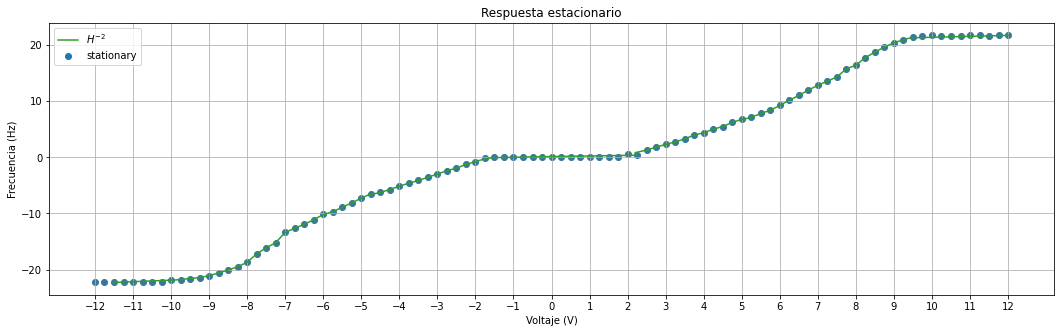

In [140]:
stationary = np.loadtxt(barrido_stationary_fname, delimiter=',', skiprows=1)
if False: # cambiar a True si no tuviera inversa para tratar de hacerla funcion
    prev_val = -np.inf
    for i in range(len(stationary[:,1])):
        stationary[i,1] = max(stationary[i,1], prev_val)
        prev_val = stationary[i,1]
H = interp1d(stationary[:,1], stationary[:,0])

plt.figure(figsize=(18, 5))
t = np.linspace(np.min(stationary[:,1]), np.max(stationary[:,1]), 100)
plt.scatter(stationary[:,0], stationary[:,1], label='stationary')
plt.scatter(stationary[:,0], np.mean(stationary[:,2:], axis=1), alpha=.1) # cambiar esto por estetica
plt.plot(H(t), t, color='tab:green', label='$H^{-2}$') # H^-1^-1
plt.grid()
plt.xticks(np.arange(-12, 12.5))
plt.ylabel('Frecuencia (Hz)')
plt.xlabel('Voltaje (V)')
plt.legend()
plt.title('Respuesta estacionario')

Step - Ziegler-Nichols

In [12]:
times = [0.5, 2.5]
step_height = 6

reset_board()
pos, vel = set_voltage_read_data(0)
time.sleep(2)
ziegler = [(0, 0, vel, pos)] # tiempo, accion, vel, pos

ti = time.time()
while time.time() - ti < times[0]:
    pos, vel = set_voltage_read_data(0)
    ziegler.append((time.time() - ti - times[0], 0, vel, pos))
while time.time() - ti < times[1]:
    pos, vel = set_voltage_read_data(step_height)
    ziegler.append((time.time() - ti - times[0], step_height, vel, pos))

print('listo')
set_voltage_read_data(0)

ziegler = np.array(ziegler)
step_fname = f'ziegler_nichols_step_{step_height}.txt'
np.savetxt(step_fname, ziegler, delimiter=',', header='time,action,vel,pos')

listo


In [13]:
ziegler = np.loadtxt(step_fname, delimiter=',', skiprows=1)

In [102]:
# stationaries
max_res = np.mean(ziegler[np.where(ziegler[:,0] > .75),2])
t_step = ziegler[np.argmax(ziegler[:,1] > 1),0]

# tangent
dy = np.gradient(ziegler[:,2])
dx = np.gradient(ziegler[:,0])
max_deriv_idx = np.argmax(dy/dx)

tang_m = dy[max_deriv_idx] / dx[max_deriv_idx]
tang_off = ziegler[max_deriv_idx,0]
tang_b = ziegler[max_deriv_idx,2]
tangent = tang_m * (ziegler[:,0] - tang_off) + tang_b

# ko
y_min_step = np.mean(ziegler[np.where(ziegler[:,1] < 0.5),1])
y_max_step = np.mean(ziegler[np.where(ziegler[:,1] > 0.5),1])
y_min_res = np.mean(ziegler[np.where(ziegler[:,1] < 0.5),2])
y_max_res = np.mean(ziegler[np.where(ziegler[:,0] > 1),2])

t_step_idx = np.argmax(np.gradient(ziegler[:,1]))
t0 = ziegler[t_step_idx, 0]

t1 = ziegler[np.argmin(np.abs(tangent - y_min_res)), 0] - t0
t1 = max(t1, 1e-10)
t2 = ziegler[np.argmin(np.abs(tangent - y_max_res)), 0] - t1 - t0

dx = y_max_step - y_min_step
dy = y_max_res - y_min_res

Text(0.5, 1.0, 'ziegler-nichols analysis')

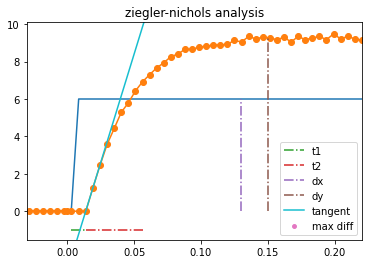

In [17]:
plt.plot(ziegler[:,0], ziegler[:,1])
plt.plot(ziegler[:,0], ziegler[:,2], '-o')
plt.scatter(ziegler[max_deriv_idx,0], ziegler[max_deriv_idx,2], s=15, color='tab:pink', label='max diff')
plt.plot([t0, t0 + t1], [-1, -1], label='t1', ls='-.')
plt.plot([t0 + t1, t0 + t1 + t2], [-1, -1], label='t2', ls='-.')
plt.plot([.13, .13], [0, dx], label='dx', ls='-.')
plt.plot([.15, .15], [0, dy], label='dy', ls='-.')
limx = plt.xlim()
limx=(-.03, .22)
limy = plt.ylim()
plt.plot(ziegler[:,0], tangent, color='tab:cyan', label='tangent')
plt.xlim(limx)
plt.ylim(limy)
plt.legend()
plt.title('ziegler-nichols analysis')

In [111]:
ko = (dx * t2) / (dy * t1)

def get_PID_params(mode, ko=ko):
    mode = mode.upper()
    if mode == 'P':
        return ko, 0, 0
    elif mode == 'PI':
        return .9 * ko, .27 * ko / t1, 0
    elif mode == 'PD':
        return 1.6 * ko, 0, .6 * ko * t1
    elif mode == 'PID':
        return 1.2 * ko, .6 * ko / t1, .6 * ko * t1
    else:
        raise Exception('Bad mode')
        
ko

2.5044369024918756

Trials

In [215]:
kp, ki, kd = get_PID_params('PID', ko=ko)


for w in np.geomspace(3, 100, 20):
    print(w)
    s = lambda t: np.sin(w*t) * 6
    #s = lambda t: 6

    d = pid_var_set_point_H(kp, ki, kd, s, H, 1000, f'zn_PID_sp_sin_w{w}_H.txt', min_action=np.min(stationary[:,1]), max_action=np.max(stationary[:,1]))
    #d = pid_var_set_point(kp, ki, kd, s, 2000, 'zn_PID_sp_sin_k_over_4.txt')
    #d = pid_fixed_set_point(kp, ki, kd, 6, 1000, 'zn_PD_sp6_k_over_4.txt')
    #plot_pid_data(d)
    time.sleep(.2)

3.0
kp: 3.0053242829902507
ki: 137.53975712992252
kd: 0.01641702412888351
average dt: 0.005300436019897461


100%|██████████████████████████████████████| 1000/1000 [00:05<00:00, 182.08it/s]


3.60805183028104
kp: 3.0053242829902507
ki: 137.53975712992252
kd: 0.01641702412888351
average dt: 0.00529360294342041


100%|██████████████████████████████████████| 1000/1000 [00:05<00:00, 181.80it/s]


4.339346003331453
kp: 3.0053242829902507
ki: 137.53975712992252
kd: 0.01641702412888351
average dt: 0.005304028987884521


100%|██████████████████████████████████████| 1000/1000 [00:05<00:00, 181.32it/s]


5.218861763180922
kp: 3.0053242829902507
ki: 137.53975712992252
kd: 0.01641702412888351
average dt: 0.005310237407684326


100%|██████████████████████████████████████| 1000/1000 [00:05<00:00, 181.46it/s]


6.276641245542887
kp: 3.0053242829902507
ki: 137.53975712992252
kd: 0.01641702412888351
average dt: 0.005324537754058838


100%|██████████████████████████████████████| 1000/1000 [00:05<00:00, 181.49it/s]


7.548815644666159
kp: 3.0053242829902507
ki: 137.53975712992252
kd: 0.01641702412888351
average dt: 0.005312180519104004


100%|██████████████████████████████████████| 1000/1000 [00:05<00:00, 181.78it/s]


9.078839367730627
kp: 3.0053242829902507
ki: 137.53975712992252
kd: 0.01641702412888351
average dt: 0.005342400074005127


100%|██████████████████████████████████████| 1000/1000 [00:05<00:00, 180.45it/s]


10.918974332522687
kp: 3.0053242829902507
ki: 137.53975712992252
kd: 0.01641702412888351
average dt: 0.0053082132339477535


100%|██████████████████████████████████████| 1000/1000 [00:05<00:00, 181.83it/s]


13.132075108416723
kp: 3.0053242829902507
ki: 137.53975712992252
kd: 0.01641702412888351
average dt: 0.005335521697998047


100%|██████████████████████████████████████| 1000/1000 [00:05<00:00, 181.10it/s]


15.793735876770347
kp: 3.0053242829902507
ki: 137.53975712992252
kd: 0.01641702412888351
average dt: 0.005299253463745117


100%|██████████████████████████████████████| 1000/1000 [00:05<00:00, 181.77it/s]


18.994872545718856
kp: 3.0053242829902507
ki: 137.53975712992252
kd: 0.01641702412888351
average dt: 0.005285682678222656


100%|██████████████████████████████████████| 1000/1000 [00:05<00:00, 180.46it/s]


22.844828218178662
kp: 3.0053242829902507
ki: 137.53975712992252
kd: 0.01641702412888351
average dt: 0.005309360027313232


100%|██████████████████████████████████████| 1000/1000 [00:05<00:00, 181.00it/s]


27.475108088351817
kp: 3.0053242829902507
ki: 137.53975712992252
kd: 0.01641702412888351
average dt: 0.0052854371070861815


100%|██████████████████████████████████████| 1000/1000 [00:05<00:00, 181.67it/s]


33.04387134178239
kp: 3.0053242829902507
ki: 137.53975712992252
kd: 0.01641702412888351
average dt: 0.00529407262802124


100%|██████████████████████████████████████| 1000/1000 [00:05<00:00, 181.82it/s]


39.741333491429735
kp: 3.0053242829902507
ki: 137.53975712992252
kd: 0.01641702412888351
average dt: 0.005314245223999024


100%|██████████████████████████████████████| 1000/1000 [00:05<00:00, 181.78it/s]


47.79626368052074
kp: 3.0053242829902507
ki: 137.53975712992252
kd: 0.01641702412888351
average dt: 0.005299313068389893


100%|██████████████████████████████████████| 1000/1000 [00:05<00:00, 182.04it/s]


57.48379888436601
kp: 3.0053242829902507
ki: 137.53975712992252
kd: 0.01641702412888351
average dt: 0.005305311679840088


100%|██████████████████████████████████████| 1000/1000 [00:05<00:00, 182.10it/s]


69.13484192541465
kp: 3.0053242829902507
ki: 137.53975712992252
kd: 0.01641702412888351
average dt: 0.005359795093536377


100%|██████████████████████████████████████| 1000/1000 [00:05<00:00, 181.89it/s]


83.1473643150609
kp: 3.0053242829902507
ki: 137.53975712992252
kd: 0.01641702412888351
average dt: 0.005299496650695801


100%|██████████████████████████████████████| 1000/1000 [00:05<00:00, 181.84it/s]


100.0
kp: 3.0053242829902507
ki: 137.53975712992252
kd: 0.01641702412888351
average dt: 0.005320601463317871


100%|██████████████████████████████████████| 1000/1000 [00:05<00:00, 181.88it/s]


In [160]:
kp, ki, kd = get_PID_params('PID', ko=ko/4)
kp, ki, kd

(0.7513310707475627, 34.38493928248063, 0.004104256032220878)

set_point: 6
kp: 1
ki: 0
kd: 0
average dt: 0.0053042244911193845


100%|██████████████████████████████████████| 1000/1000 [00:05<00:00, 185.08it/s]


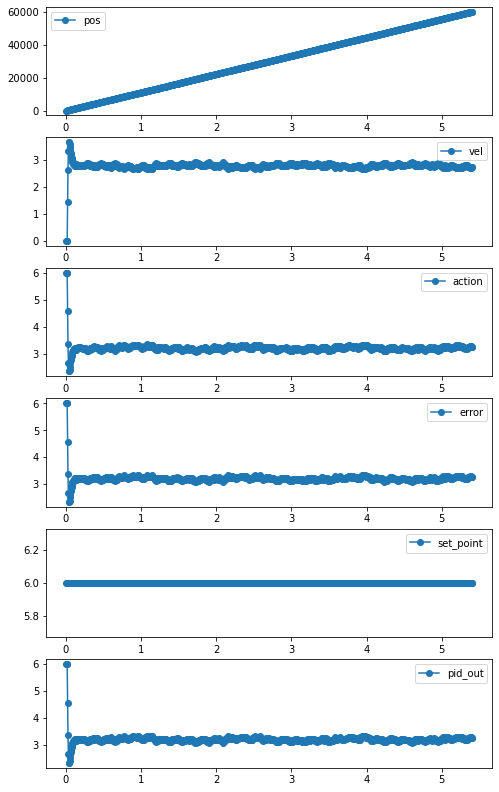

In [191]:
#kp, ki, kd = get_PID_params('PID', ko=ko)
kp, ki, kd = 1, 0, 0

w = 1
s = lambda t: np.sin(w*t) * 6
#s = lambda t: 6

d = pid_var_set_point_H(kp, ki, kd, s, H, 5000, None, min_action=np.min(stationary[:,1]), max_action=np.max(stationary[:,1]))
#d = pid_var_set_point(kp, ki, kd, s, 2000, 'zn_PID_sp_sin_k_over_4.txt')
plot_pid_data(d)

Position

In [56]:
def pid_pos_var_set_point(kp: float, ki: float, kd: float, set_point: callable, n_points: int, fname=None):
    '''
        set_point is a function of time: set_point(t: float) -> float
        H is the transfer function inverse: H(f: float) -> V: float
    '''
    print('kp:', kp)
    print('ki:', ki)
    print('kd:', kd)
    dt_tries = 100
    dt = 0
    for _ in range(dt_tries):
        dt += get_serial_dt()
    dt /= dt_tries
    print('average dt:', dt)
    pid = PID_Clamp(kp, ki, kd, dt, 0, -12, 12)
    data = np.zeros((n_points, 7)) # (time, pos, vel, action, error, set_point, pid_out)

    # trial
    voltage = 0.0
    reset_board()
    time.sleep(0.5)
    ti = time.time()
    for i in tqdm(range(n_points)):
        pos, vel = set_voltage_read_data(voltage)
        fixed_set_point = set_point(time.time() - ti)
        pid.set_point = fixed_set_point
        action, error = pid(pos)
        voltage = round(action, 6)
        data[i] = (time.time() - ti, pos, vel, voltage, error, fixed_set_point, 0)

    if fname is not None:
        np.savetxt(fname, data, delimiter=',', header='time,pos,vel,action,error,set_point,pid_out')
    
    reset_board()

    return data

def pid_pos_fixed_set_point(kp: float, ki: float, kd: float, set_point: float, n_points: int, fname=None):
    print('set_point:', set_point)
    
    data = pid_pos_var_set_point(kp, ki, kd, lambda t: set_point, n_points, fname)
    return data

In [ ]:
for kp in np.arange(0.005, 0.01, 0.001):
    print(kp)
    d = pid_pos_fixed_set_point(kp, 0, 0, 1000, 500)

In [ ]:
kp, ki, kd = get_PID_params('PID', ko=.008)
kp, ki, kd = 0.009, .08, 0.1
d = pid_pos_fixed_set_point(kp, ki, kd, 1000, 2000, 'pid_set_pos2.txt')
plot_pid_data(d)

In [74]:
reset_board()

set_point: 0
kp: 0.008
ki: 0.3
kd: 0.15
average dt: 0.005298690795898437


100%|██████████████████████████████████████| 5000/5000 [00:27<00:00, 184.17it/s]


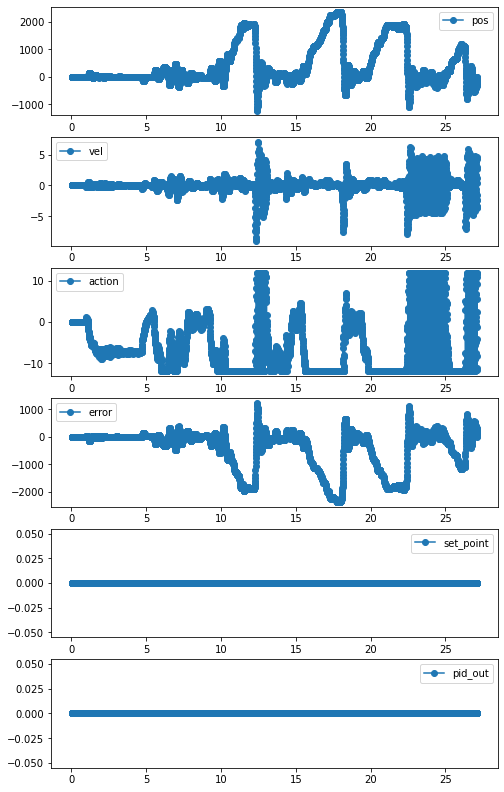

In [276]:
kp, ki, kd = 0.008, .3, 0.15

w = 1
s = lambda t: np.sin(w*t) * 8000

d = pid_pos_fixed_set_point(kp, ki, kd, 0, 5000, 'pid_set_pos_forzado_6.txt')
plot_pid_data(d)

In [236]:
kp, ki, kd = 0.009, .08, 0.1

for w in np.geomspace(1, 70, 20):
    print(w)
    s = lambda t: np.sin(w*t) * 8000

    d = pid_pos_var_set_point(kp, ki, kd, s, 1000, f'pid_var_pos_sin_w{w}.txt')
    #plot_pid_data(d)
    time.sleep(.2)

1.0
kp: 0.009
ki: 0.08
kd: 0.1
average dt: 0.005293703079223633


100%|██████████████████████████████████████| 1000/1000 [00:05<00:00, 183.25it/s]


1.2505769598936667
kp: 0.009
ki: 0.08
kd: 0.1
average dt: 0.005304994583129882


100%|██████████████████████████████████████| 1000/1000 [00:05<00:00, 183.63it/s]


1.5639427326168855
kp: 0.009
ki: 0.08
kd: 0.1
average dt: 0.00530470609664917


100%|██████████████████████████████████████| 1000/1000 [00:05<00:00, 183.36it/s]


1.9558307480038184
kp: 0.009
ki: 0.08
kd: 0.1
average dt: 0.005302784442901612


 41%|███████████████▊                       | 407/1000 [00:02<00:03, 182.79it/s]


KeyboardInterrupt: 

kp: 0.009
ki: 0.08
kd: 0.1
average dt: 0.005310604572296143


100%|██████████████████████████████████████| 1000/1000 [00:05<00:00, 183.95it/s]


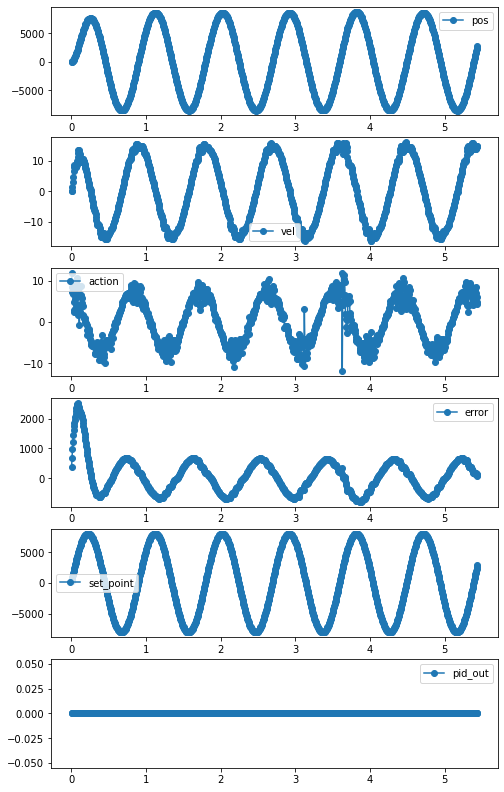

In [229]:
s = lambda t: np.sin(7*t) * 8000

d = pid_pos_var_set_point(kp, ki, kd, s, 1000, None)
plot_pid_data(d)

In [237]:
reset_board()